In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import numpy as np
import umap
import umap.umap_ as umap
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

In [2]:
# Establish a connection to the SQLite database
conn = sqlite3.connect('Data/users_data.db')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Query to retrieve table names from the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch all the table names
table_names = cursor.fetchall()

# Print the table names
for name in table_names:
    print(name[0])

Users


In [3]:
# Read data from the database into a DataFrame
users = pd.read_sql('SELECT * FROM Users', conn)

# Close the cursor and connection
cursor.close()
conn.close()

In [4]:
users.head(3)

,id,username,age,gender,fav_entertainment,least_fav_entertainment,likes,dislikes,movie_watching_freq,show_watching_freq,reading_freq
0,1,Roger7748,27,F,"Books, Movies",None,"Thriller, Drama","Classics, Action",Weekly,Rarely,Monthly
1,2,Anthony6859,32,F,Books,None,"Fantasy, Romance, Drama, Thriller, Animation","Sci-Fi, Horror, Action, Adventure",Monthly,Monthly,Daily
2,3,Joe6044,30,F,Movies,Books,"Drama, Fantasy, Comedy, Romance","Classics, Adventure, History, Sci-Fi",Daily,Monthly,Rarely


In [5]:
users_encoded = users

In [6]:
users_encoded = users_encoded.drop(columns=['id', 'username'])

In [7]:
users_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   age                      10000 non-null  int64 
 1   gender                   10000 non-null  object
 2   fav_entertainment        10000 non-null  object
 3   least_fav_entertainment  10000 non-null  object
 4   likes                    10000 non-null  object
 5   dislikes                 10000 non-null  object
 6   movie_watching_freq      10000 non-null  object
 7   show_watching_freq       10000 non-null  object
 8   reading_freq             10000 non-null  object
dtypes: int64(1), object(8)
memory usage: 703.3+ KB


In [8]:
def convert_to_binary(value):
    if value == 'F':
        return 0
    elif value == 'M':
        return 1
    else:
        return np.nan

In [9]:
users_encoded['gender'] = users_encoded['gender'].apply(lambda x: convert_to_binary(x))


In [10]:
users_encoded

,age,gender,fav_entertainment,least_fav_entertainment,likes,dislikes,movie_watching_freq,show_watching_freq,reading_freq
0,27,0,"Books, Movies",None,"Thriller, Drama","Classics, Action",Weekly,Rarely,Monthly
1,32,0,Books,None,"Fantasy, Romance, Drama, Thriller, Animation","Sci-Fi, Horror, Action, Adventure",Monthly,Monthly,Daily
2,30,0,Movies,Books,"Drama, Fantasy, Comedy, Romance","Classics, Adventure, History, Sci-Fi",Daily,Monthly,Rarely
3,25,0,"Tv-shows, Movies",None,"Action, Comedy, Romance","Mystery, Thriller, Documentary, Classics",Monthly,Monthly,Monthly
4,28,0,Movies,Tv-shows,"Comedy, Animation, Thriller, Drama, Fantasy","Classics, Adventure, Horror, Sci-Fi, History",Monthly,Never,Monthly
...,...,...,...,...,...,...,...,...,...
9995,21,1,"Movies, Tv-shows",None,"Horror, War","Romance, Mystery",Daily,Monthly,Monthly
9996,46,1,Books,Movies,History,Romance,Rarely,Weekly,Daily
9997,30,1,Movies,Tv-shows,"Adventure, Mystery, Drama, Sci-Fi",Fantasy,Weekly,Rarely,Rarely
9998,56,1,Tv-shows,None,Horror,"Romance, Mystery, Documentary",Daily,Monthly,Daily


In [11]:
# Preprocess the columns to standardize the combinations
users_encoded['fav_entertainment'] = users_encoded['fav_entertainment'].apply(lambda x: ', '.join(sorted(x.split(', '))))
users_encoded['least_fav_entertainment'] = users_encoded['least_fav_entertainment'].apply(lambda x: ', '.join(sorted(x.split(', '))))

# One-hot encode 'fav_entertainment' column
fav_encoded = users_encoded['fav_entertainment'].str.get_dummies(', ').add_prefix('fav_')

# One-hot encode 'least_fav_entertainment' column
least_fav_encoded = users_encoded['least_fav_entertainment'].str.get_dummies(', ').add_prefix('least_fav_')

# Concatenate the new one-hot encoded columns with the original DataFrame
users_encoded = pd.concat([users_encoded, fav_encoded, least_fav_encoded], axis=1)

# Drop the original columns if needed
users_encoded.drop(['fav_entertainment', 'least_fav_entertainment'], axis=1, inplace=True)

In [12]:
# Preprocess the columns to standardize the combinations
users_encoded['likes'] = users_encoded['likes'].apply(lambda x: ', '.join(sorted(x.split(', '))))
users_encoded['dislikes'] = users_encoded['dislikes'].apply(lambda x: ', '.join(sorted(x.split(', '))))

# One-hot encode 'likes' column
likes_encoded = users_encoded['likes'].str.get_dummies(', ').add_prefix('likes_')

# One-hot encode 'dislikes' column
dislikes_encoded = users_encoded['dislikes'].str.get_dummies(', ').add_prefix('dislikes_')

# Concatenate the new one-hot encoded columns with the original DataFrame
users_encoded = pd.concat([users_encoded, likes_encoded, dislikes_encoded], axis=1)

# Drop the original columns if needed
users_encoded.drop(['likes', 'dislikes'], axis=1, inplace=True)

In [13]:
# Define the encoding map
encoding_map = {'Never': 0, 'Rarely': 1, 'Monthly': 2, 'Weekly': 3, 'Daily': 4}

# Apply the mapping to encode the variables in users_encoded
users_encoded['movie_watching_freq'] = users_encoded['movie_watching_freq'].map(encoding_map)
users_encoded['show_watching_freq'] = users_encoded['show_watching_freq'].map(encoding_map)
users_encoded['reading_freq'] = users_encoded['reading_freq'].map(encoding_map)

In [14]:
users_encoded

,age,gender,movie_watching_freq,show_watching_freq,reading_freq,fav_Books,fav_Movies,fav_Tv-shows,least_fav_Books,least_fav_Movies,...,dislikes_Comedy,dislikes_Documentary,dislikes_Drama,dislikes_Fantasy,dislikes_History,dislikes_Horror,dislikes_Mystery,dislikes_Romance,dislikes_Sci-Fi,dislikes_Thriller
0,27,0,3,1,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,32,0,2,2,4,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,30,0,4,2,1,0,1,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,25,0,2,2,2,0,1,1,0,0,...,0,1,0,0,0,0,1,0,0,1
4,28,0,2,0,2,0,1,0,0,0,...,0,0,0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,21,1,4,2,2,0,1,1,0,0,...,0,0,0,0,0,0,1,1,0,0
9996,46,1,1,3,4,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
9997,30,1,3,1,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9998,56,1,4,2,4,0,0,1,0,0,...,0,1,0,0,0,0,1,1,0,0


In [15]:
users_encoded.columns

Index(['age', 'gender', 'movie_watching_freq', 'show_watching_freq',
       'reading_freq', 'fav_Books', 'fav_Movies', 'fav_Tv-shows',
       'least_fav_Books', 'least_fav_Movies', 'least_fav_None',
       'least_fav_Tv-shows', 'likes_Action', 'likes_Adventure',
       'likes_Animation', 'likes_Biography', 'likes_Classics', 'likes_Comedy',
       'likes_Documentary', 'likes_Drama', 'likes_Fantasy', 'likes_History',
       'likes_Horror', 'likes_Mystery', 'likes_Romance', 'likes_Sci-Fi',
       'likes_Thriller', 'likes_War', 'dislikes_Action', 'dislikes_Adventure',
       'dislikes_Animation', 'dislikes_Classics', 'dislikes_Comedy',
       'dislikes_Documentary', 'dislikes_Drama', 'dislikes_Fantasy',
       'dislikes_History', 'dislikes_Horror', 'dislikes_Mystery',
       'dislikes_Romance', 'dislikes_Sci-Fi', 'dislikes_Thriller'],
      dtype='object')

In [16]:
%pip install phik

Note: you may need to restart the kernel to use updated packages.


In [17]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [18]:
from phik import phik_matrix

interval columns not set, guessing: ['likes_Action', 'likes_Adventure', 'likes_Animation', 'likes_Biography', 'likes_Classics', 'likes_Comedy', 'likes_Documentary', 'likes_Drama', 'likes_Fantasy', 'likes_History', 'likes_Horror', 'likes_Mystery', 'likes_Romance', 'likes_Sci-Fi', 'likes_Thriller', 'likes_War', 'dislikes_Action', 'dislikes_Adventure', 'dislikes_Animation', 'dislikes_Classics', 'dislikes_Comedy', 'dislikes_Documentary', 'dislikes_Drama', 'dislikes_Fantasy', 'dislikes_History', 'dislikes_Horror', 'dislikes_Mystery', 'dislikes_Romance', 'dislikes_Sci-Fi', 'dislikes_Thriller']


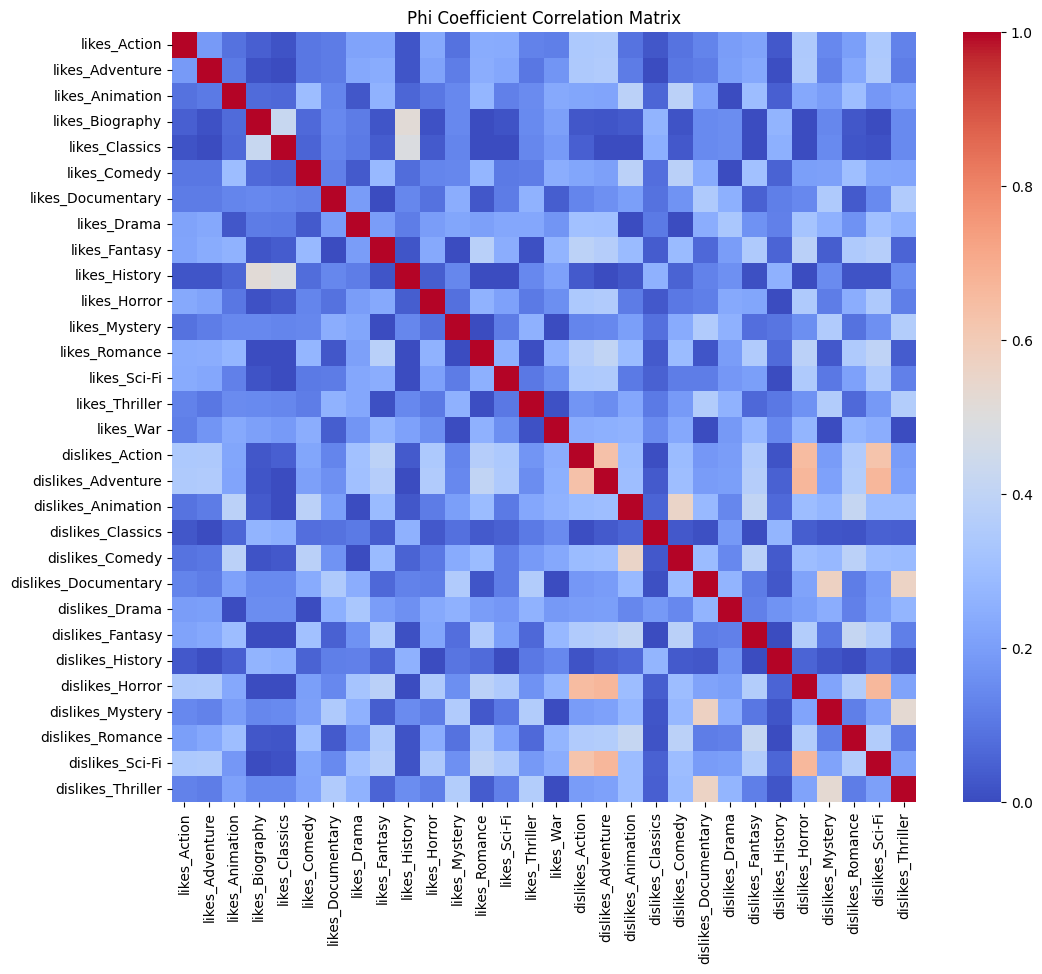

In [19]:
# Extract the subset of your DataFrame with the selected columns
subset_users_encoded = users_encoded.drop(columns=['age', 'gender', 'movie_watching_freq', 'show_watching_freq',
       'reading_freq', 'fav_Books', 'fav_Movies', 'fav_Tv-shows',
       'least_fav_Books', 'least_fav_Movies', 'least_fav_None',
       'least_fav_Tv-shows'])

# Calculate the Phi Coefficient matrix
phi_matrix = phik_matrix(subset_users_encoded)

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(phi_matrix, cmap='coolwarm')
plt.title('Phi Coefficient Correlation Matrix')
plt.show()

In [21]:
data_clustering = users_encoded

In [22]:
feat_scaler = MinMaxScaler()
data_scaled = feat_scaler.fit_transform(data_clustering)

In [23]:
dispersion = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data_scaled)
    dispersion.append(kmeans.inertia_)

c:\Users\Ultilizador\Documents\GitHub\Capstone-Project\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c:\Users\Ultilizador\Documents\GitHub\Capstone-Project\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ultilizador\Documents\GitHub\Capstone-Project\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ultilizador\Documents\GitHub\Capstone-Project\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ultilizador\Documents\GitHub\Capstone-Project\env\Lib\site-packa

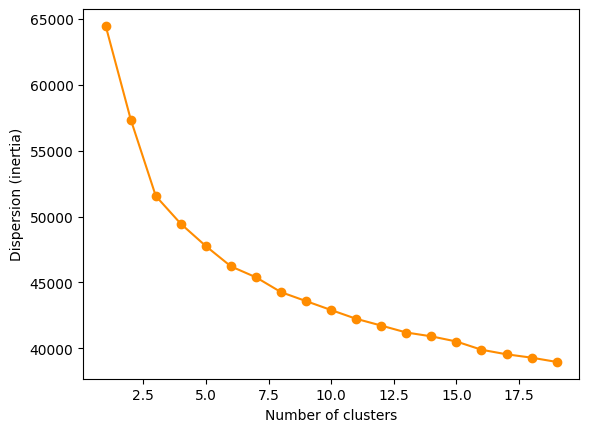

In [24]:
plt.plot(range(1, 20), dispersion, marker='o', color='darkorange')
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion (inertia)')
plt.show()

Initialy tried with 5 clusters as suggested by the plots of dispersion and silhouette scores, but 4 worked better, we analyze that later in the t-SNE and UMAP visualizations. (to be changed)

In [25]:
kmeans_solution = KMeans(n_clusters=5, random_state=42).fit(data_scaled)
cluster_labels = kmeans_solution.predict(data_scaled)
cluster_labels += 1  # Add 1 to shift the labels from 0-4 to 1-5
data_clustering['cluster'] = cluster_labels

c:\Users\Ultilizador\Documents\GitHub\Capstone-Project\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


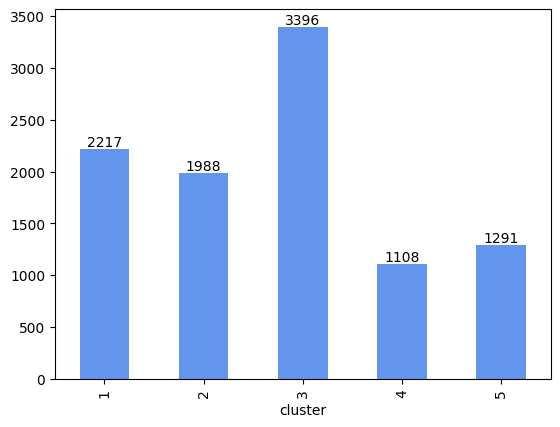

In [26]:
# Group the data by 'cluster' and calculate the size of each group
cluster_counts = data_clustering.groupby('cluster').size()

# Create the bar plot
ax = cluster_counts.plot(kind='bar', color='cornflowerblue')

# Add text annotations above each bar
for i, count in enumerate(cluster_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')

# Display the plot
plt.show()

In [28]:
cluster_kmeans = data_clustering['cluster']

In [29]:
tsne_model_ = TSNE(n_components=2, perplexity=500, random_state=42)
tsne_cust = tsne_model_.fit_transform(data_scaled)

In [30]:
def visualize_dimensionality_reduction(data, labels):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
    plt.title('Dimensionality Reduction Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.colorbar(label='Cluster')
    plt.show()

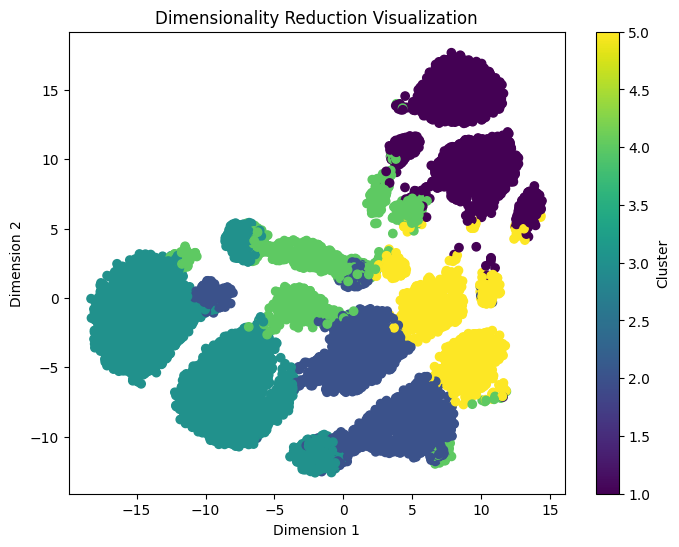

In [31]:
visualize_dimensionality_reduction(tsne_cust, np.array(cluster_kmeans))

In [32]:
%pip install umap

In [41]:
umap_object = umap.UMAP(n_neighbors=300, min_dist=0.9, random_state=42)

In [42]:
%%time
umap_embedding = umap_object.fit_transform(data_scaled)

c:\Users\Ultilizador\Documents\GitHub\Capstone-Project\env\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


CPU times: total: 1min 39s
Wall time: 1min 9s


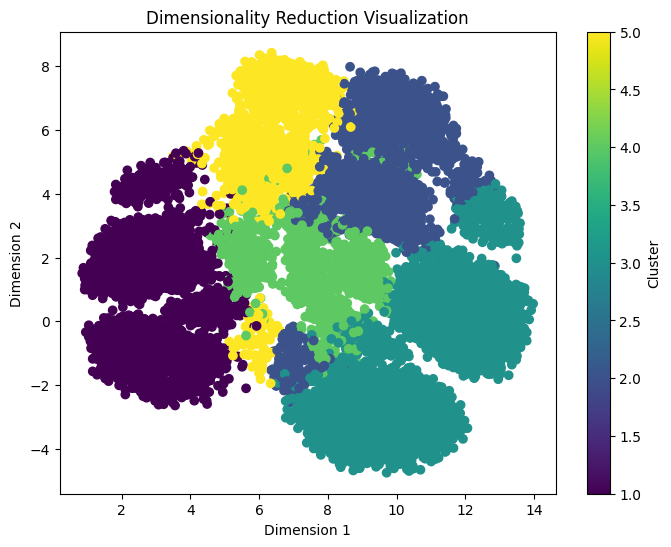

In [37]:
visualize_dimensionality_reduction(umap_embedding, np.array(cluster_kmeans))

In [38]:
data_clustering.columns

Index(['age', 'gender', 'movie_watching_freq', 'show_watching_freq',
       'reading_freq', 'fav_Books', 'fav_Movies', 'fav_Tv-shows',
       'least_fav_Books', 'least_fav_Movies', 'least_fav_None',
       'least_fav_Tv-shows', 'likes_Action', 'likes_Adventure',
       'likes_Animation', 'likes_Biography', 'likes_Classics', 'likes_Comedy',
       'likes_Documentary', 'likes_Drama', 'likes_Fantasy', 'likes_History',
       'likes_Horror', 'likes_Mystery', 'likes_Romance', 'likes_Sci-Fi',
       'likes_Thriller', 'likes_War', 'dislikes_Action', 'dislikes_Adventure',
       'dislikes_Animation', 'dislikes_Classics', 'dislikes_Comedy',
       'dislikes_Documentary', 'dislikes_Drama', 'dislikes_Fantasy',
       'dislikes_History', 'dislikes_Horror', 'dislikes_Mystery',
       'dislikes_Romance', 'dislikes_Sci-Fi', 'dislikes_Thriller', 'cluster'],
      dtype='object')

In [39]:
# Define the reverse mapping by swapping keys and values
reverse_encoding_map = {v: k for k, v in encoding_map.items()}

# Apply the reverse mapping to decode the variables
data_clustering['movie_watching_freq'] = data_clustering['movie_watching_freq'].map(reverse_encoding_map)
data_clustering['show_watching_freq'] = data_clustering['show_watching_freq'].map(reverse_encoding_map)
data_clustering['reading_freq'] = data_clustering['reading_freq'].map(reverse_encoding_map)

In [40]:
# Group by 'cluster' and calculate descriptive statistics for each feature
grouped_stats = data_clustering.groupby('cluster').agg({
    'age': 'mean',
    'gender': 'mean',
    'movie_watching_freq': lambda x: x.mode().iloc[0],  # Frequencies of movie_watching_freq by cluster
    'show_watching_freq': lambda x: x.mode().iloc[0],  # Frequencies of show_watching_freq by cluster
    'reading_freq': lambda x: x.mode().iloc[0],  # Frequencies of reading_freq by cluster
    'fav_Books': 'mean',
    'fav_Movies': 'mean',
    'fav_Tv-shows': 'mean',
    'least_fav_Books': 'mean',
    'least_fav_Movies': 'mean',
    'least_fav_None': 'mean',
    'least_fav_Tv-shows': 'mean',
    'likes_Action': 'mean',
    'likes_Adventure': 'mean',
    'likes_Animation': 'mean',
    'likes_Classics': 'mean',
    'likes_Comedy': 'mean',
    'likes_Documentary': 'mean',
    'likes_Drama': 'mean',
    'likes_Fantasy': 'mean',
    'likes_History': 'mean',
    'likes_Horror': 'mean',
    'likes_Mystery': 'mean',
    'likes_Romance': 'mean',
    'likes_Sci-Fi': 'mean',
    'likes_Thriller': 'mean',
    'dislikes_Action': 'mean',
    'dislikes_Adventure': 'mean',
    'dislikes_Animation': 'mean',
    'dislikes_Classics': 'mean',
    'dislikes_Comedy': 'mean',
    'dislikes_Documentary': 'mean',
    'dislikes_Drama': 'mean',
    'dislikes_Fantasy': 'mean',
    'dislikes_History': 'mean',
    'dislikes_Horror': 'mean',
    'dislikes_Mystery': 'mean',
    'dislikes_Romance': 'mean',
    'dislikes_Sci-Fi': 'mean',
    'dislikes_Thriller': 'mean',
})

# Creating a DataFrame from the computed statistics
db_clusters_df = pd.DataFrame(grouped_stats)

# Rounding the values to two decimal places
db_clusters_df = db_clusters_df.round(2)

# Displaying the resulting dataset
db_clusters_df.T


cluster,1,2,3,4,5
age,30.82,23.89,30.22,50.19,23.34
gender,0.0,1.0,1.0,0.74,0.02
movie_watching_freq,Daily,Weekly,Weekly,Never,Daily
show_watching_freq,Never,Weekly,Never,Daily,Daily
reading_freq,Weekly,Never,Monthly,Monthly,Never
fav_Books,0.74,0.0,0.76,0.71,0.0
fav_Movies,0.75,0.75,0.78,0.0,0.73
fav_Tv-shows,0.01,0.72,0.0,0.73,0.76
least_fav_Books,0.08,0.47,0.07,0.03,0.45
least_fav_Movies,0.08,0.04,0.05,0.58,0.08


o que está abaixo tem de ser alterado porque o chat escreveu muita coisa mal, mas o formato está bom  só é preciso trocar algumas palavra

### Cluster 1: Female Readers

- **Age**: Around 30.82 years old on average.
- **Gender**: Predominantly female (0.0).
  
#### Preferences:

- **Media Consumption**:
    - Rarely watches movies but reads weekly.
    - Likes a variety of genres, especially Drama, Horror, and Thriller.
  
- **Favorable Choices**:
    - Prefers a mix of books and movies.
    - Dislikes Fantasy and Romance genres.

#### Summary:

This cluster primarily consists of females around the age of 31 who prefer reading over movie-watching. They enjoy a diverse range of genres, particularly favoring Drama, Horror, and Thriller while avoiding Fantasy and Romance.

### Cluster 2: Media Enthusiasts

- **Age**: Around 23.89 years old on average.
- **Gender**: Predominantly male (1.0).
  
#### Preferences:

- **Media Consumption**:
    - Watches movies and shows weekly but rarely reads.
    - Enjoys Adventure, Animation, Comedy, and Drama.
  
- **Favorable Choices**:
    - Favors Adventure, Animation, Comedy, and Drama genres.
    - Dislikes Documentary and History genres.

#### Summary:

This cluster primarily consists of young males aged around 24 who are frequent viewers of Adventure, Animation, Comedy, and Drama. They tend to avoid Documentary and History genres.

### Cluster 3: Genre-Neutral Viewers

- **Age**: Around 30.22 years old on average.
- **Gender**: Predominantly male (1.0).
  
#### Preferences:

- **Media Consumption**:
    - Rarely watches movies and shows, reads monthly.
    - Neutral in genre preferences with balanced means.

#### Summary:

This cluster represents mostly male individuals in their thirties who show a neutral stance across various genre preferences. They engage less in movie-watching and more in monthly reading.

### Cluster 4: Occasional Movie Buffs

- **Age**: Around 50.19 years old on average.
- **Gender**: Mixed, slightly female-leaning (0.74).
  
#### Preferences:

- **Media Consumption**:
    - Rarely watches movies but reads monthly.
    - Neutral in genre preferences due to balanced means.

#### Summary:

This cluster involves a mixed age group leaning towards older individuals who tend to read more than watch movies. They exhibit a neutral stance across various genre preferences.

### Cluster 5: Avid Movie Fans

- **Age**: Around 23.34 years old on average.
- **Gender**: Mostly male (0.02).
  
#### Preferences:

- **Media Consumption**:
    - Watches movies and shows daily but rarely reads.
    - Enjoys Animation, Comedy, and Fantasy but dislikes Documentary and Drama.

#### Summary:

This cluster mostly comprises young males in their early twenties who are daily consumers of movies and shows, favoring Animation, Comedy, and Fantasy while avoiding Documentary and Drama genres.


In [45]:
data_clustering

,age,gender,movie_watching_freq,show_watching_freq,reading_freq,fav_Books,fav_Movies,fav_Tv-shows,least_fav_Books,least_fav_Movies,...,dislikes_Documentary,dislikes_Drama,dislikes_Fantasy,dislikes_History,dislikes_Horror,dislikes_Mystery,dislikes_Romance,dislikes_Sci-Fi,dislikes_Thriller,cluster
0,27,0,Weekly,Rarely,Monthly,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,32,0,Monthly,Monthly,Daily,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
2,30,0,Daily,Monthly,Rarely,0,1,0,1,0,...,0,0,0,1,0,0,0,1,0,1
3,25,0,Monthly,Monthly,Monthly,0,1,1,0,0,...,1,0,0,0,0,1,0,0,1,5
4,28,0,Monthly,Never,Monthly,0,1,0,0,0,...,0,0,0,1,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,21,1,Daily,Monthly,Monthly,0,1,1,0,0,...,0,0,0,0,0,1,1,0,0,2
9996,46,1,Rarely,Weekly,Daily,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,4
9997,30,1,Weekly,Rarely,Rarely,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,3
9998,56,1,Daily,Monthly,Daily,0,0,1,0,0,...,1,0,0,0,0,1,1,0,0,4


In [46]:
#export data for builiding the classification model
data_clustering.to_csv('Data/classification_data.csv', index=False)